In [511]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [560]:
runs = pd.read_csv('new_strava_data/activities.csv')

runs['Activity Date'] = pd.to_datetime(runs['Activity Date'], format='%b %d, %Y, %I:%M:%S %p')

rel_cols = [
    'Activity Date',
    'Elapsed Time',
    'Distance',
    'Moving Time',
    'Average Heart Rate',
    'Average Speed',
    'Elevation Gain',
    'Average Grade',
    'Grade Adjusted Distance',
]

recent_selector = runs['Activity Date'] > '2023-02-01'
recent_selector_end = runs['Activity Date'] < '2025-06-30'

runs_sub = runs[recent_selector & recent_selector_end][rel_cols]

# Only use rows with HR data
runs_sub = runs_sub[~pd.isna(runs_sub['Average Heart Rate'])]

runs_sub = runs_sub.sort_values('Activity Date')

In [561]:
runs_sub

,Activity Date,Elapsed Time,Distance,Moving Time,Average Heart Rate,Average Speed,Elevation Gain,Average Grade,Grade Adjusted Distance
186,2023-06-13 12:31:12,5183,16.19,5173.0,150.332565,3.129987,132.241562,-0.032769,16335.099609
187,2023-06-14 13:29:39,6253,19.33,6248.0,163.199295,3.094531,160.107269,-0.027421,19529.900391
189,2023-06-17 12:17:06,4779,15.38,4773.0,159.116028,3.223423,197.498276,-0.004555,15730.099609
191,2023-06-20 13:53:34,3041,9.70,3031.0,158.414993,3.201904,82.809425,0.007225,9799.200195
192,2023-06-21 14:32:49,4204,12.97,4204.0,154.930038,3.085098,95.503609,0.011617,13035.700195
...,...,...,...,...,...,...,...,...,...
621,2025-05-21 17:09:16,2403,7.75,2221.0,168.465240,3.491702,79.854362,0.051579,7907.700195
622,2025-05-23 16:19:54,3875,11.95,3562.0,163.702515,3.357170,67.620621,0.005017,12068.099609
623,2025-05-24 13:28:12,3540,11.27,3535.0,158.763184,3.189397,74.570335,-0.002661,11374.700195
624,2025-05-25 16:53:10,4000,13.76,3997.0,172.458801,3.444691,70.883217,0.007263,13850.200195


# Remove outliers

In [524]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

# Apply to both heart rate and speed
runs_sub = remove_outliers_iqr(runs_sub, 'Average Heart Rate')
runs_sub = remove_outliers_iqr(runs_sub, 'Average Speed')
runs_sub = remove_outliers_iqr(runs_sub, 'Elevation Gain')

# Remove elevation outliers
runs_sub = runs_sub[runs_sub['Elevation Gain'] < 100]
runs_sub.shape

(179, 9)

# Control for speed + elevation

In [525]:
import statsmodels.api as sm

X = runs_sub[['Average Speed', 'Elevation Gain']]
y = runs_sub['Average Heart Rate']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

runs_sub['hr_corrected'] = model.resid
runs_sub['hr_moving_average'] = runs_sub['hr_corrected'].rolling(window=10).mean()
runs_sub = runs_sub[10:] # Ignore initial nans

# Linear Trend

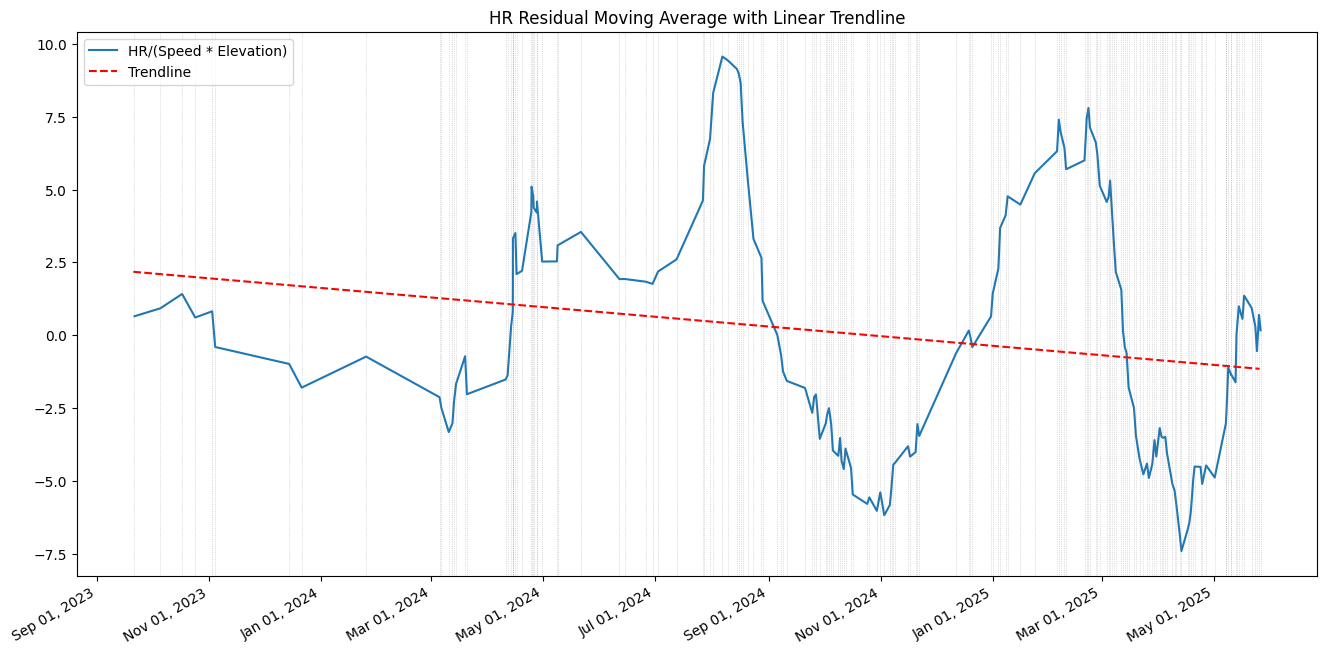

In [526]:
import matplotlib.dates as mdates

# Create a larger figure
fig, ax = plt.subplots(figsize=(16, 8))  # Width = 16 inches, Height = 8 inches

# Main line plot
ax.plot(runs_sub['Activity Date'], runs_sub['hr_moving_average'], label='HR/(Speed * Elevation)')

# Fit linear trendline
x = runs_sub['Activity Date']
y = runs_sub['hr_moving_average']
x_numeric = x.map(datetime.toordinal)
z = np.polyfit(x_numeric, y, 1)
p = np.poly1d(z)

# Convert ordinal dates to matplotlib's float format
trendline_x = mdates.date2num([datetime.fromordinal(int(val)) for val in x_numeric])
trendline_y = p(x_numeric)

# Plot the trendline using float dates (no warning)
ax.plot(trendline_x, trendline_y, color='red', linestyle='--', label='Trendline')

# Add small vertical tick marks for each run
for run_date in runs_sub['Activity Date']:
    ax.axvline(run_date, color='gray', linestyle=':', linewidth=0.5, alpha=0.5)

# Format x-axis to show dates nicely
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))
ax.figure.autofmt_xdate()  # Auto rotates date labels

ax.legend()
ax.set_title('HR Residual Moving Average with Linear Trendline')
plt.show()

In [527]:
slope = z[0]
intercept = z[1]

print(f"Slope: {slope:.6f} bpm per unit speed per day")
print(f"Intercept: {intercept:.3f} bpm per unit speed")

if slope < 0:
    print("Heart rate per unit speed is decreasing over time — indicating improving cardiovascular efficiency.")
elif slope > 0:
    print("Heart rate per unit speed is increasing over time — indicating increasing effort or fatigue.")
else:
    print("No clear trend in heart rate per unit speed over time.")

Slope: -0.005434 bpm per unit speed per day
Intercept: 4016.545 bpm per unit speed
Heart rate per unit speed is decreasing over time — indicating improving cardiovascular efficiency.


In [528]:
days_span = (runs_sub['Activity Date'].max() - runs_sub['Activity Date'].min()).days
days_span

612

In [529]:
total_decrease = slope * days_span  # slope is negative, so this will be negative
total_decrease

np.float64(-3.325453632181689)

In [530]:
print(f"Over {days_span} days, your heart rate per unit speed decreased by {abs(total_decrease):.3f} bpm per unit speed.")

Over 612 days, your heart rate per unit speed decreased by 3.325 bpm per unit speed.


In [531]:
# HR decrease = slope decrease (bpm per unit speed) × speed (mph)

p_s = [('7:30', 8.0), ('8:00', 7.5), ('9:00', 6.67)]

for p, s in p_s:
    hr_decrease = total_decrease * s
    print(f"HR improved {hr_decrease:.0f} bpm at {p} pace")

HR improved -27 bpm at 7:30 pace
HR improved -25 bpm at 8:00 pace
HR improved -22 bpm at 9:00 pace


# Other ways to visualize

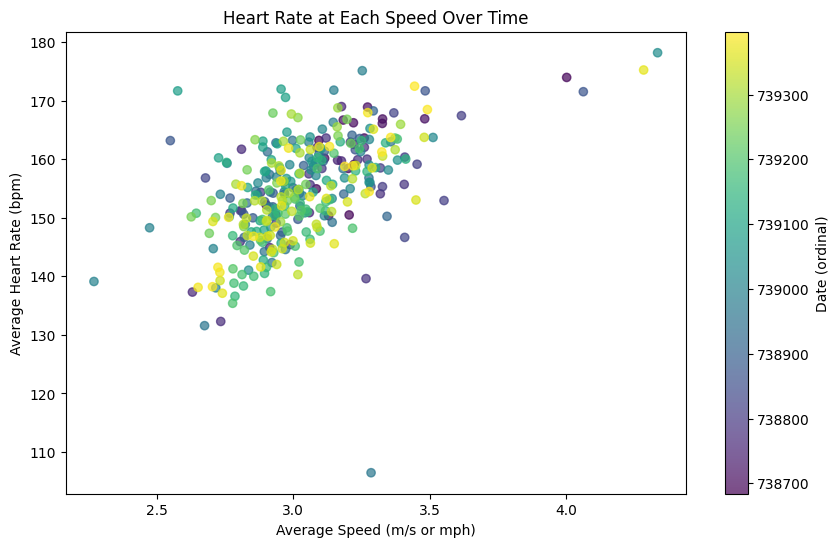

In [562]:
# Assume runs_sub has columns: 'Average Speed', 'Average Heart Rate', 'Activity Date'
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    runs_sub['Average Speed'],
    runs_sub['Average Heart Rate'],
    c=runs_sub['Activity Date'].map(pd.Timestamp.toordinal),  # Convert dates to numeric
    cmap='viridis',
    alpha=0.7
)
plt.colorbar(scatter, label='Date (ordinal)')
plt.xlabel('Average Speed (m/s or mph)')
plt.ylabel('Average Heart Rate (bpm)')
plt.title('Heart Rate at Each Speed Over Time')
plt.show()

/var/folders/dx/sggrdnfn5mqgszgsy2l049dr0000gn/T/ipykernel_20282/1439019882.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for speed_bin, group in runs_sub.groupby('Speed Bin'):


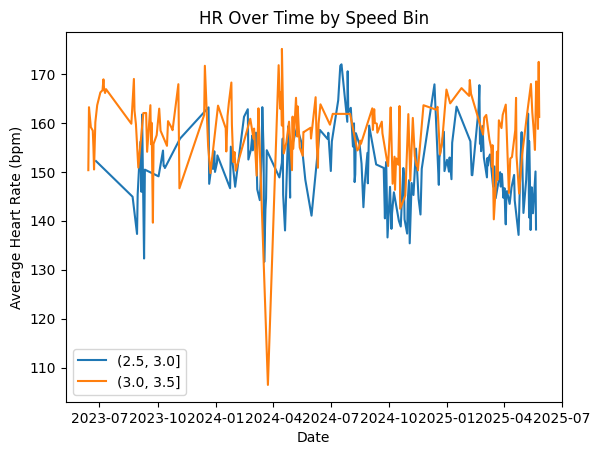

In [565]:
runs_sub['Speed Bin'] = pd.cut(runs_sub['Average Speed'], bins=np.arange(2.5, 4.0, 0.5))

for speed_bin, group in runs_sub.groupby('Speed Bin'):
    plt.plot(group['Activity Date'], group['Average Heart Rate'], label=str(speed_bin))

plt.xlabel('Date')
plt.ylabel('Average Heart Rate (bpm)')
plt.title('HR Over Time by Speed Bin')
plt.legend()
plt.show()